In [2]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [5]:
df = pd.read_csv('balletmasters_final.csv')
df_link = pd.read_csv('balletmasters_numoflink.csv')
df = pd.merge(df_link,df,left_on='Name', right_on='ballet_master')
# df = df[['Name','num_links','num_awards','num_countries','num_influences','num_employer','num_education','gender','birth_year']]
# df = df.dropna()

df = df[df['num_awards'] != 0]
data = df

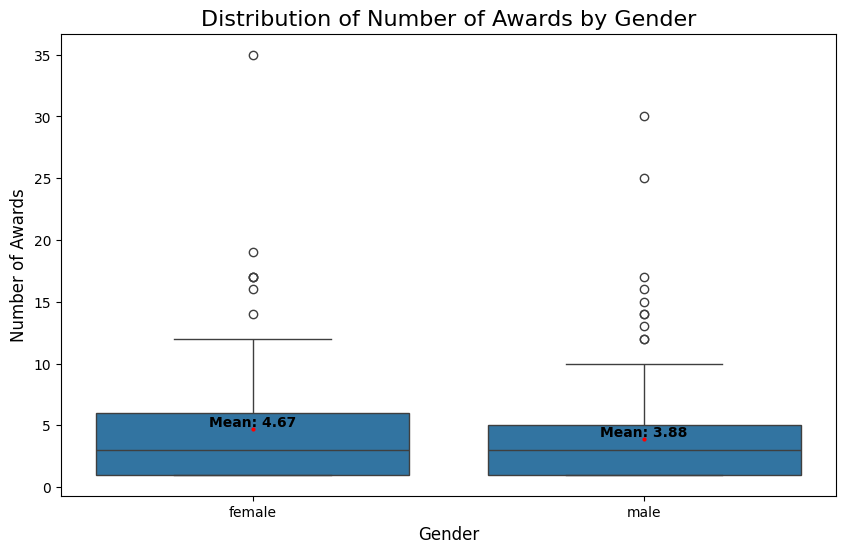

        count      mean       std  min  25%  50%  75%   max
gender                                                     
female  115.0  4.669565  4.960761  1.0  1.0  3.0  6.0  35.0
male    189.0  3.883598  3.998297  1.0  1.0  3.0  5.0  30.0

t-statistic: -1.515060398386364
p-value: 0.13080302239968403


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure the gender column is properly formatted
data['gender'] = data['gender'].str.lower()

# Create the box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='gender', y='num_awards', data=data)

# Calculate means for each gender
means = data.groupby('gender')['num_awards'].mean()

# Add means to the plot
for i, gender in enumerate(means.index):
    plt.plot(i, means[gender], marker='o', color='red', markersize=2)
    plt.text(i, means[gender], f'Mean: {means[gender]:.2f}', 
             ha='center', va='bottom', fontweight='bold')

# Add title and labels
plt.title('Distribution of Number of Awards by Gender', fontsize=16)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Number of Awards', fontsize=12)

# Show the plot
plt.show()

# Calculate and print some summary statistics
print(data.groupby('gender')['num_awards'].describe())

# Perform a t-test to check if the difference is statistically significant
from scipy import stats

male_awards = data[data['gender'] == 'male']['num_awards']
female_awards = data[data['gender'] == 'female']['num_awards']

t_statistic, p_value = stats.ttest_ind(male_awards, female_awards)
print(f"\nt-statistic: {t_statistic}")
print(f"p-value: {p_value}")

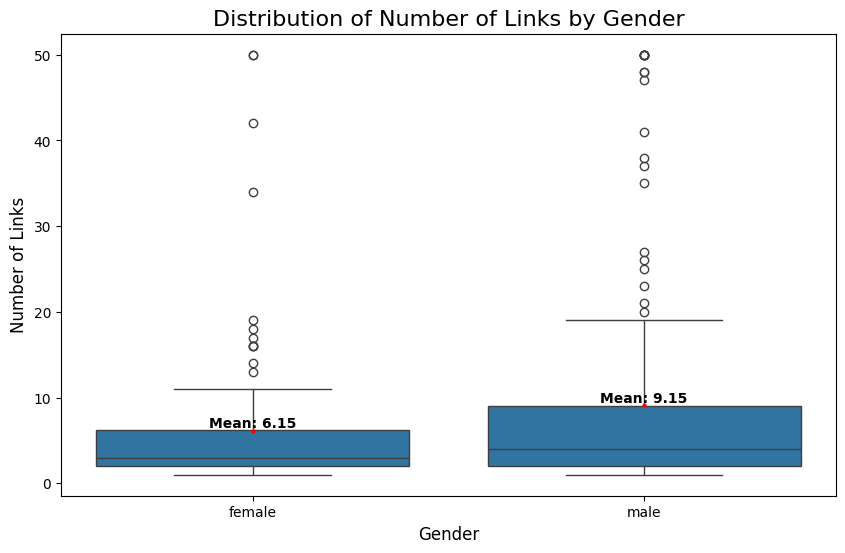

        count      mean        std  min  25%  50%   75%   max
gender                                                       
female   96.0  6.145833   9.116762  1.0  2.0  3.0  6.25  50.0
male    150.0  9.146667  12.616909  1.0  2.0  4.0  9.00  50.0

t-statistic: 2.01699922325541
p-value: 0.04479092420876122


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure the gender column is properly formatted
data['gender'] = data['gender'].str.lower()

# Create the box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='gender', y='num_links', data=data)

# Calculate means for each gender
means = data.groupby('gender')['num_links'].mean()

# Add means to the plot
for i, gender in enumerate(means.index):
    plt.plot(i, means[gender], marker='o', color='red', markersize=2)
    plt.text(i, means[gender], f'Mean: {means[gender]:.2f}', 
             ha='center', va='bottom', fontweight='bold')

# Add title and labels
plt.title('Distribution of Number of Links by Gender', fontsize=16)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Number of Links', fontsize=12)

# Show the plot
plt.show()

# Calculate and print some summary statistics
print(data.groupby('gender')['num_links'].describe())

# Perform a t-test to check if the difference is statistically significant
from scipy import stats

male_awards = data[data['gender'] == 'male']['num_links']
male_awards = male_awards.dropna()
female_awards = data[data['gender'] == 'female']['num_links']
female_awards = female_awards.dropna()

t_statistic, p_value = stats.ttest_ind(male_awards, female_awards)
print(f"\nt-statistic: {t_statistic}")
print(f"p-value: {p_value}")

In [15]:
male_awards

1       7.0
15      NaN
23      6.0
24      NaN
25      NaN
       ... 
641     2.0
643     1.0
644    11.0
647     5.0
652     2.0
Name: num_links, Length: 189, dtype: float64

In [3]:
# Split the 'employer' column by ';' and explode it
df_exploded = df.assign(employer=df['employer'].str.split(';')).explode('employer')

# Remove any leading/trailing whitespace from 'employer' entries
df_exploded['employer'] = df_exploded['employer'].str.strip()

# Group by 'employer' and sum 'num_awards'
employer_awards = df_exploded.groupby('employer')['num_awards'].sum().reset_index()

# Display the result
min_awards = employer_awards['num_awards'].min()
max_awards = employer_awards['num_awards'].max()

employer_awards['normalized_awards'] = (employer_awards['num_awards'] - min_awards) / (max_awards - min_awards)

# Display the result
employer_awards

,employer,num_awards,normalized_awards
0,American Ballet Theatre,10,0.090909
1,Armenian Ensemble of Song and Dance after Tatu...,3,0.020202
2,Armenian State Pedagogical University,2,0.010101
3,Azerbaijan State Academic Opera and Ballet The...,9,0.080808
4,Bahor,16,0.151515
...,...,...,...
84,White Oak Dance Project,10,0.090909
85,Yekaterinburg Opera and Ballet Theatre,3,0.020202
86,Yerevan Dancing Art State College,11,0.101010
87,Yerevan Opera Theater,17,0.161616


In [4]:
employer_links = df_exploded.groupby('employer')['num_links'].sum().reset_index()
min_links = employer_links['num_links'].min()
max_links = employer_links['num_links'].max()

employer_links['normalized_links'] = (employer_links['num_links'] - min_links) / (max_links - min_links)

# Display the result
employer_links

,employer,num_links,normalized_links
0,American Ballet Theatre,27.0,0.252336
1,Armenian Ensemble of Song and Dance after Tatu...,2.0,0.018692
2,Armenian State Pedagogical University,1.0,0.009346
3,Azerbaijan State Academic Opera and Ballet The...,6.0,0.056075
4,Bahor,2.0,0.018692
...,...,...,...
84,White Oak Dance Project,27.0,0.252336
85,Yekaterinburg Opera and Ballet Theatre,1.0,0.009346
86,Yerevan Dancing Art State College,10.0,0.093458
87,Yerevan Opera Theater,17.0,0.158879


In [5]:
employer = pd.merge(employer_awards,employer_links,left_on='employer', right_on='employer')
employer['normalized_prestige'] = employer['normalized_awards'] + employer['normalized_links']
sorted_employer = employer.sort_values(by='normalized_prestige',ascending=False)
sorted_employer.head(20)

,employer,num_awards,normalized_awards,num_links,normalized_links,normalized_prestige
39,Mariinsky Theatre,93,0.929293,107.0,1.000000,1.929293
63,Russian Institute of Theatre Arts,100,1.000000,76.0,0.710280,1.710280
48,New York City Ballet,20,0.191919,86.0,0.803738,0.995658
16,Bolshoi Theatre,32,0.313131,54.0,0.504673,0.817804
82,Vaganova Academy of Russian Ballet,21,0.202020,61.0,0.570093,0.772114
47,Navoi Theater,58,0.575758,18.0,0.168224,0.743982
49,New York University,11,0.101010,50.0,0.467290,0.568300
6,Ballet Russe de Monte Carlo,5,0.040404,55.0,0.514019,0.554423
15,Bolshoi Kamenny Theatre,5,0.040404,50.0,0.467290,0.507694
68,School of American Ballet,4,0.030303,50.0,0.467290,0.497593


In [6]:
top_20_employers = sorted_employer.nlargest(20, 'normalized_prestige')

# Filter the original DataFrame to include only rows where the employer is in the top 20
top_20_employees = df_exploded[df_exploded['employer'].isin(top_20_employers['employer'])]

top_20_employees

,Name,QID,num_links,ballet_master,country_of_citizenship,employer,birth_year,gender,educatedat,studentofLabel,studentLabel,influence,award,num_awards,num_countries,num_influences,num_employer,num_education
23,Aleksandr Aleksandrovich Lapauri,Q4254150,6.0,Aleksandr Aleksandrovich Lapauri,Russia,Russian Institute of Theatre Arts,1926.0,male,higher education; Russian Institute of Theatre...,Rostislav Zakharov,NaN,Rostislav Zakharov,Merited Artist of the RSFSR; Order of the Badg...,3,1,1,1,2
26,Aleksandr Radunsky,Q4387977,5.0,Aleksandr Radunsky,Russia,Bolshoi Theatre,1912.0,male,NaN,NaN,NaN,NaN,Order of the Red Banner of Labour; Order of th...,3,1,0,1,0
31,Aleksey Andreyev,Q19907011,2.0,Aleksey Andreyev,Russia,Mariinsky Theatre,1920.0,male,Vaganova Academy of Russian Ballet,NaN,NaN,NaN,Merited Artist of the RSFSR; Honored Artist of...,2,1,0,3,1
31,Aleksey Andreyev,Q19907011,2.0,Aleksey Andreyev,Russia,Bolshoi Theatre of Belarus,1920.0,male,Vaganova Academy of Russian Ballet,NaN,NaN,NaN,Merited Artist of the RSFSR; Honored Artist of...,2,1,0,3,1
32,Aleksey Yermolayev,Q4176577,7.0,Aleksey Yermolayev,Russia,Bolshoi Theatre of Belarus,1910.0,male,Vaganova Academy of Russian Ballet,NaN,Q111653564,Q111653564,Merited Artist of the RSFSR; People's Artist o...,8,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
632,Yevhen Changa,Q30345073,4.0,Yevhen Changa,Latvia; Russia,Russian Institute of Theatre Arts,1920.0,male,NaN,Rostislav Zakharov,NaN,Rostislav Zakharov,Order of the Badge of Honour; Stalin Prize; Ho...,3,2,1,1,0
640,Yury Grigorovich,Q2622333,12.0,Yury Grigorovich,Russia,Mariinsky Theatre,1927.0,male,Vaganova Academy of Russian Ballet; Russian In...,NaN,NaN,NaN,Hero of Socialist Labour; People's Artist of t...,30,1,0,1,2
644,Yury Zhdanov,Q4178491,11.0,Yury Zhdanov,Russia,Russian Institute of Theatre Arts,1925.0,male,Russian Institute of Theatre Arts,NaN,NaN,NaN,People's Artist of the RSFSR; Order of the Red...,3,1,0,1,1
647,Zare Moeradovitsj Moeradjan,Q4307808,5.0,Zare Moeradovitsj Moeradjan,Russia,Bolshoi Theatre,1913.0,male,Moscow State Academy of Choreography; Yerevan ...,NaN,NaN,NaN,Order of the Badge of Honour; Honored Art Work...,2,1,0,6,3


In [7]:

G = nx.DiGraph()
# Add nodes
for person in df['Name']:
    G.add_node(person)

# Add edges based on studentLabel (Person -> Teacher)
for i, row in df.iterrows():
    if pd.notna(row['studentLabel']):
        students = row['studentLabel'].split(';')
        for student in students:
            student = student.strip()
            if student:  
                G.add_edge(student, row['Name'])

# Add edges based on studentofLabel (Teacher <- Student)
for i, row in df.iterrows():
    if pd.notna(row['studentofLabel']):
        teachers = row['studentofLabel'].split(';')
        for teacher in teachers:
            teacher = teacher.strip()
            if teacher:  
                G.add_edge(row['Name'], teacher)

# Calculate centrality metrics
in_degree_centrality = nx.in_degree_centrality(G)
out_degree_centrality = nx.out_degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
try:
    eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=500)
except nx.PowerIterationFailedConvergence:
    print("Eigenvector centrality did not converge with the default method.")
    # Attempt using a more robust method
    eigenvector_centrality = nx.eigenvector_centrality_numpy(G)


# Combine the centrality measures into a DataFrame
centrality_df = pd.DataFrame({
    'Name': G.nodes(),
    'In-Degree Centrality': [in_degree_centrality[node] for node in G.nodes()],
    'Out-Degree Centrality': [out_degree_centrality[node] for node in G.nodes()],
    'Betweenness Centrality': [betweenness_centrality[node] for node in G.nodes()],
    'Closeness Centrality': [closeness_centrality[node] for node in G.nodes()],
    'Eigenvector Centrality': [eigenvector_centrality[node] for node in G.nodes()],
})

In [8]:
# Add this after creating your graph G
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")

Number of nodes: 383
Number of edges: 114


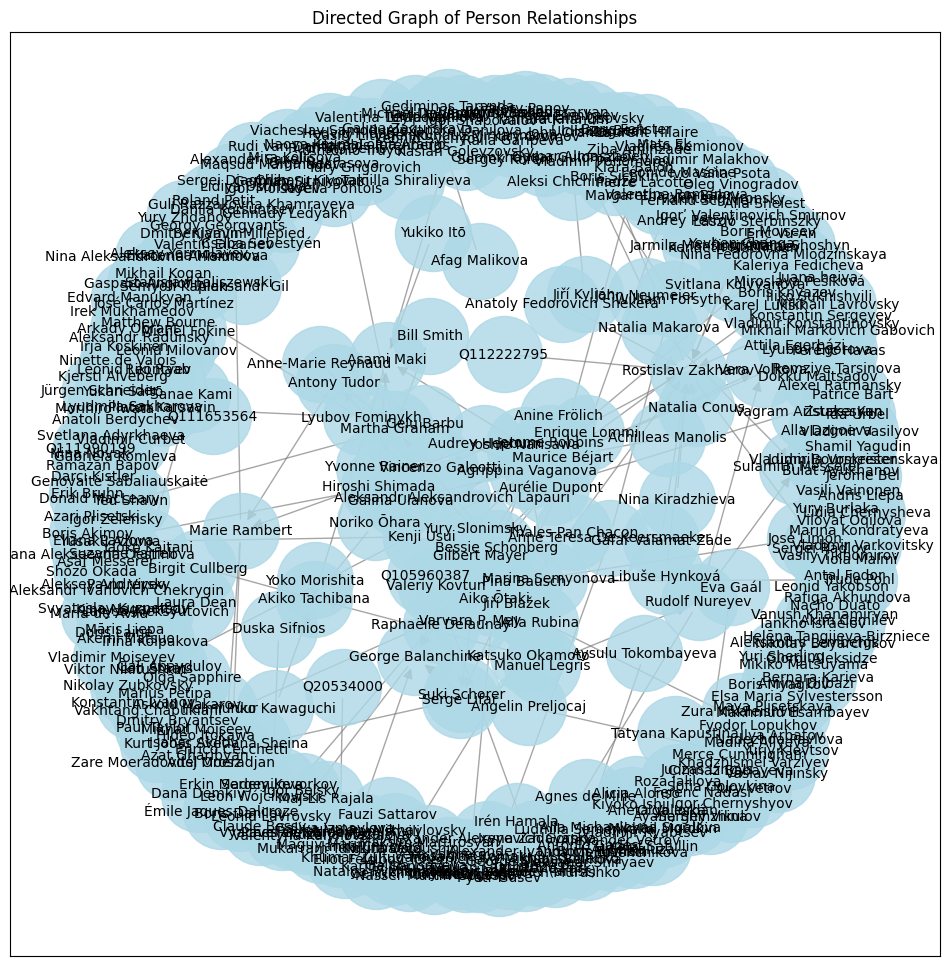

In [9]:
plt.figure(figsize=(12, 12))

# Use spring layout or another layout depending on the structure of your graph
pos = nx.spring_layout(G, k=0.3)  # k controls the distance between nodes, you can adjust it

# Draw the nodes
nx.draw_networkx_nodes(G, pos, node_size=3000, node_color='lightblue', alpha=0.8)

# Draw the edges
nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=15, edge_color='gray', alpha=0.7)

# Draw the labels
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

# Optional: Draw edge labels if you have weights or specific labels for edges
# edge_labels = nx.get_edge_attributes(G, 'label')
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Show the plot
plt.title('Directed Graph of Person Relationships')
plt.show()

### **1. Betweenness Centrality**
**Definition:**
Betweenness centrality measures how often a node (individual) appears on the shortest paths between other nodes in a network. It indicates the extent to which a person acts as a bridge or intermediary in the flow of information or influence between others.

**Interpretation:**
- A high betweenness centrality score means that the individual is a critical connector in the network, often facilitating interactions between other people. This person might control the flow of information or resources, making them influential in connecting different groups.
- For example, in a mentorship network, a person with high betweenness centrality might be someone who connects various groups of students or teachers, playing a crucial role in spreading knowledge or influence across the network.

### **2. Closeness Centrality**
**Definition:**
Closeness centrality measures how close a node is to all other nodes in the network. It is calculated as the reciprocal of the sum of the shortest path distances from the node to all other nodes. Essentially, it reflects how quickly an individual can access every other person in the network.

**Interpretation:**
- A high closeness centrality score indicates that the individual is close to all other members of the network, meaning they can quickly interact or spread information to others. They are efficiently positioned to reach out to others with minimal steps.
- In a mentorship network, a person with high closeness centrality might be someone who can easily influence or be influenced by others due to their proximity (in a network sense) to everyone else.

### **3. Eigenvector Centrality**
**Definition:**
Eigenvector centrality is a measure of a node's influence in a network, considering not just the number of connections (like degree centrality) but also the quality of those connections. A node is considered influential if it is connected to other nodes that are themselves influential.

**Interpretation:**
- A high eigenvector centrality score suggests that the individual is well-connected to other well-connected individuals, making them highly influential within the network. This metric identifies not just direct influence but also indirect influence through the network.
- In a mentorship network, someone with high eigenvector centrality might be a mentor who has not only many students but also students who themselves are or become influential, amplifying the mentor's overall influence in the network.

### **Summary:**
- **Betweenness Centrality**: Identifies key connectors or intermediaries in the network.
- **Closeness Centrality**: Measures how easily a person can reach others in the network.
- **Eigenvector Centrality**: Evaluates influence based on both direct and indirect connections, giving more weight to connections with influential individuals.


In [10]:
centrality_df

,Name,In-Degree Centrality,Out-Degree Centrality,Betweenness Centrality,Closeness Centrality,Eigenvector Centrality
0,Çimnaz Babayeva,0.000000,0.000000,0.0,0.000000,5.227762e-09
1,Éric Vu-An,0.000000,0.000000,0.0,0.000000,5.227762e-09
2,Éva Gaál,0.000000,0.002618,0.0,0.000000,5.227762e-09
3,Adél Orosz,0.000000,0.000000,0.0,0.000000,5.227762e-09
4,Agnes de Mille,0.000000,0.000000,0.0,0.000000,5.227762e-09
...,...,...,...,...,...,...
378,Trude Pohl,0.002618,0.000000,0.0,0.003490,1.352893e-04
379,Sergeĭ Radlov,0.002618,0.000000,0.0,0.016390,1.476263e-03
380,Q111020258,0.002618,0.000000,0.0,0.002618,1.191930e-06
381,Gasparo Angiolini,0.002618,0.000000,0.0,0.003490,1.352893e-04


In [11]:
top_20_employees_centrality = pd.merge(centrality_df, top_20_employees, left_on='Name', right_on='Name')
mean_centrality_top_20 = top_20_employees_centrality['Closeness Centrality'].mean()
mean_centrality_top_20

np.float64(0.0017686725429120554)

In [12]:
other_employees = df_exploded[~df_exploded['employer'].isin(top_20_employers['employer']) & df_exploded['employer'].notnull()]
other_employees_centrality = pd.merge(centrality_df, other_employees, left_on='Name', right_on='Name')
mean_centrality_others = other_employees_centrality['Closeness Centrality'].mean()
mean_centrality_others

np.float64(0.00042159342706433713)

In [13]:
data = pd.merge(centrality_df,df,on='Name')

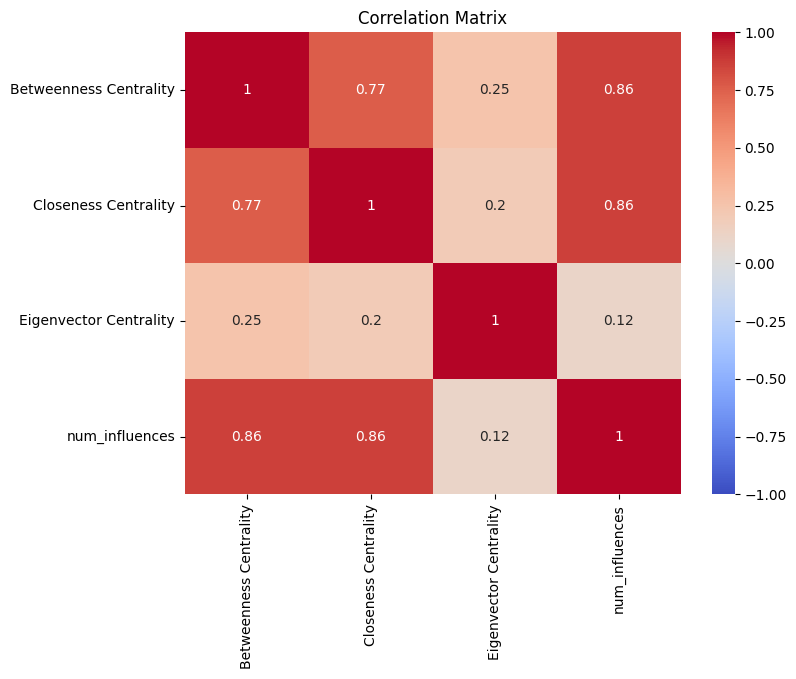

In [14]:
import seaborn as sns
corr_matrix = data[['Betweenness Centrality',	'Closeness Centrality'	,'Eigenvector Centrality', 'num_influences']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

def calculate_pvalues(df):
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

pval_matrix = calculate_pvalues(data[['Betweenness Centrality',	'Closeness Centrality'	,'Eigenvector Centrality', 'num_awards', 'num_links']])

plt.figure(figsize=(8, 6))
sns.heatmap(pval_matrix.astype(float), annot=True, cmap='coolwarm', vmin=0, vmax=0.05)
plt.title('P-value Matrix')
plt.show()

KeyError: "['Betweenness Centrality', 'Closeness Centrality', 'Eigenvector Centrality'] not in index"

In [23]:
data

,Name,In-Degree Centrality,Out-Degree Centrality,Betweenness Centrality,Closeness Centrality,Eigenvector Centrality,QID,num_links,ballet_master,country_of_citizenship,...,studentofLabel,studentLabel,influence,award,num_awards,num_countries,num_influences,num_employer,num_education,num_gender
0,Çimnaz Babayeva,0.0,0.000000,0.0,0.0,5.227762e-09,Q12848543,2.0,Çimnaz Babayeva,Azerbaijan; Russia,...,NaN,NaN,NaN,Honored Artist of the Azerbaijan SSR; People's...,3,2,0,1,2,0
1,Éric Vu-An,0.0,0.000000,0.0,0.0,5.227762e-09,Q3591402,7.0,Éric Vu-An,France,...,NaN,NaN,NaN,Officer of the Legion of Honour; Knight of the...,5,1,0,0,1,1
2,Éva Gaál,0.0,0.002618,0.0,0.0,5.227762e-09,Q109781409,3.0,Éva Gaál,Hungary,...,Ferenc Nádasi,NaN,Ferenc Nádasi,Franz Liszt Prize; Meritorius Artist of Hungary,2,1,1,0,0,0
3,Adél Orosz,0.0,0.000000,0.0,0.0,5.227762e-09,Q1225751,3.0,Adél Orosz,Hungary,...,NaN,NaN,NaN,Great Artist of Hungary Award; Kossuth Prize; ...,6,1,0,0,0,0
4,Agnes de Mille,0.0,0.000000,0.0,0.0,5.227762e-09,Q394670,19.0,Agnes de Mille,United States of America,...,NaN,NaN,NaN,Tony Award for Best Choreography; Kennedy Cent...,6,1,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,Yury Zhdanov,0.0,0.000000,0.0,0.0,5.227762e-09,Q4178491,11.0,Yury Zhdanov,Russia,...,NaN,NaN,NaN,People's Artist of the RSFSR; Order of the Red...,3,1,0,1,1,1
300,Zare Moeradovitsj Moeradjan,0.0,0.000000,0.0,0.0,5.227762e-09,Q4307808,5.0,Zare Moeradovitsj Moeradjan,Russia,...,NaN,NaN,NaN,Order of the Badge of Honour; Honored Art Work...,2,1,0,6,3,1
301,Ziba Aminzade,0.0,0.000000,0.0,0.0,5.227762e-09,Q15064009,3.0,Ziba Aminzade,Tajikistan; Russia,...,NaN,NaN,NaN,People's Artist of the USSR; People's Artist o...,2,2,0,0,0,0
302,Zsuzsa Kun,0.0,0.000000,0.0,0.0,5.227762e-09,Q617902,2.0,Zsuzsa Kun,Hungary,...,NaN,NaN,NaN,Great Artist of Hungary Award; Kossuth Prize; ...,4,1,0,0,0,0


/var/folders/xf/m7s8z1812_j3lvq4zs2f3z7w0000gn/T/ipykernel_15454/1823309537.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['num_gender'] = data['gender'].apply(lambda x: 1 if x == 'male' else 0)
/var/folders/xf/m7s8z1812_j3lvq4zs2f3z7w0000gn/T/ipykernel_15454/1122865331.py:12: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a 

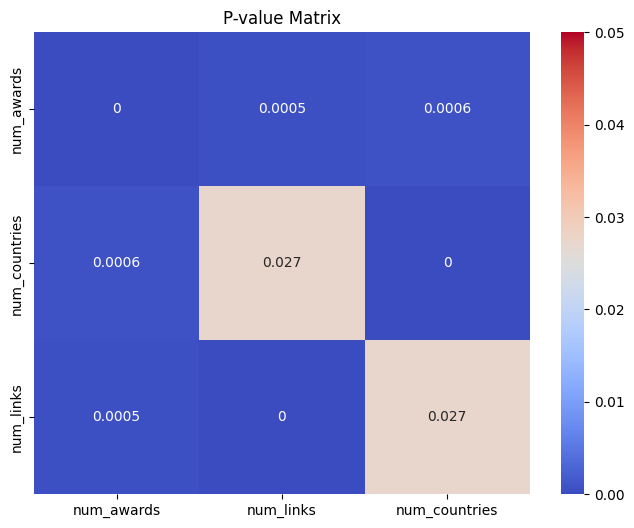

In [14]:
data['num_gender'] = data['gender'].apply(lambda x: 1 if x == 'male' else 0)
data = data[data['num_links'].notnull()]
pval_matrix = calculate_pvalues(data[['num_awards',	'num_links'	, 'num_countries']])

plt.figure(figsize=(8, 6))
sns.heatmap(pval_matrix.astype(float), annot=True, cmap='coolwarm', vmin=0, vmax=0.05)
plt.title('P-value Matrix')
plt.show()

In [27]:
print(data['num_links'].describe())
print(data['num_links'].isnull().sum())

count    246.000000
mean       7.975610
std       11.453874
min        1.000000
25%        2.000000
50%        4.000000
75%        8.000000
max       50.000000
Name: num_links, dtype: float64
58
